In [14]:
import numpy as np
import matplotlib.pyplot as plt
from src.preprocessing import process_video
from src.distance_measures import analyse_video
# from src.gaussian_noise import generate_noise_array
from src.visualizer import visualize
plt.rcParams['image.cmap'] = 'gray'

In [16]:
L=100
size=800

In [17]:
label_video = process_video('images/cheese_gel.avi', threshold=0.3, skip_size=12, size=size)[:15]

In [18]:
F_list, G_list = analyse_video(label_video, L=L)

  0%|          | 0/15 [00:00<?, ?it/s]

In [23]:
import numpy as np
# import imageio
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.color import label2rgb
from IPython.display import display, clear_output

def visualize(video, F_list, G_list, F_noise=np.array([]), G_noise=np.array([]), L=100, save=False):
    """Visualizes a list of data overlaps, can compare with one dataset"""
    fig, ax = plt.subplots(1,4, figsize=(14,6), gridspec_kw={'width_ratios': [1, 1, 1, 2]})
    # fig.subplots_adjust(wspace=0.4)
    plt.tight_layout()

    colors = cm.Blues(np.linspace(0.2, 1, len(video)))
    # plots = []

    for i in range(len(F_list)):
        M = video[i].shape[0] - L
        bx = (L, M, M, L, L)
        by = (L, L, M, M, L)

        ax[3].plot(bx, by, '-r')
        ax[3].imshow(label2rgb(video[i], bg_label=0))
        ax[3].set_title('video frame #144')

        ax[0].plot(F_list[i], color=colors[i])
        ax[0].set_xlabel('r')
        ax[0].set_ylabel('pixels')
        ax[0].set_title('Area overlap')
        ax[1].plot(F_list[i]/G_list[i], color=colors[i])
        ax[1].set_xlabel('r')
        ax[1].set_ylabel('percentage in decimal')
        ax[1].set_title('Fractional area overlap')
        
        ax[2].plot((F_list[i])[1:]-(F_list[i])[:-1], color=colors[i])
        ax[2].set_xlabel('r')
        ax[2].set_ylabel('pixels')
        ax[2].set_title('Curve overlap')
        

        # ax[0].set_ylim([0,2500])
        # ax[1].set_ylim([0,0.07])
        # ax[2].set_ylim([0,50])

        if save:
            filename = 'frames/subplot_{:03d}.png'.format(i)
            fig.savefig(filename)
            # plots.append(fig)

        display(fig)
        clear_output(wait = True)

    if F_noise.size and G_noise.size:
        ax[0].plot(F_noise, color='r')
        ax[1].plot(F_noise/G_noise, color='r')
        ax[2].plot(F_noise[1:]-F_noise[:-1], color='r')

    if save:
        filename = 'frames/subplot_{:03d}.png'.format(i+1)
        fig.savefig(filename)
        # plots.append(fig)

        # with imageio.get_writer('animation.gif', mode='I') as writer:
        #     for plot in plots:
        #         writer.append_data(imageio.core.image_as_uint(plot.canvas.renderer.buffer_rgba()))
    plt.show()

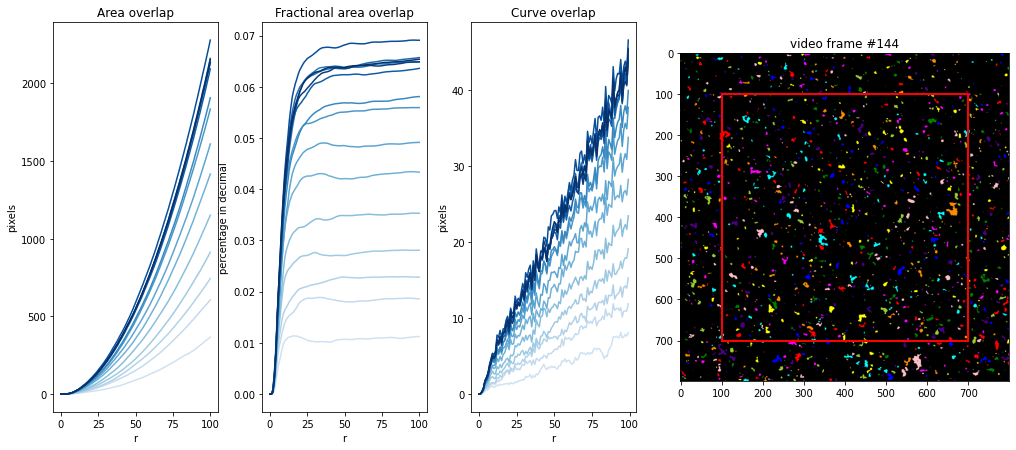

In [24]:
visualize(label_video, F_list, G_list)